In [1]:
import matplotlib.pyplot as plt
import aniposelib
%matplotlib widget
import numpy as np
import pandas as pd
import os, cv2, sys, shutil

## Choosing Equidistant Points on a tail

In [2]:
calibration_ = aniposelib.cameras.CameraGroup.load('/mnt/soma_cifs/Iyer/Filming/02092022a/calibrationwater_0900/calibration.toml')

In [3]:
def get_traces():
    p0 = np.load(f'/home/iyer_la/Documents/TailAnnotated/tadpole_stage57_Cam0-Aditya-2022-11-04/labeled-data/40_4100-5280/Camera1img0108_pts00000.npy')
    p1 = np.load(f'/home/iyer_la/Documents/TailAnnotated/tadpole_stage57_Cam1-Aditya-2022-11-04/labeled-data/40_4100-5280/Camera1img0108_pts00000.npy')
    p2 = np.load(f'/home/iyer_la/Documents/TailAnnotated/tadpole_stage57_Cam2-Aditya-2022-11-04/labeled-data/40_4100-5280/Camera1img0108_pts00000.npy')
    return p0, p1, p2

In [4]:
def get_imgs():
    p0 = cv2.imread(f'/home/iyer_la/Documents/TailAnnotated/tadpole_stage57_Cam0-Aditya-2022-11-04/labeled-data/40_4100-5280/img0108.png')
    p1 = cv2.imread(f'/home/iyer_la/Documents/TailAnnotated/tadpole_stage57_Cam1-Aditya-2022-11-04/labeled-data/40_4100-5280/img0108.png')
    p2 = cv2.imread(f'/home/iyer_la/Documents/TailAnnotated/tadpole_stage57_Cam2-Aditya-2022-11-04/labeled-data/40_4100-5280/img0108.png')
    return p0, p1, p2

In [5]:
p0, p1, p2 = get_traces()
i0, i1, i2 = get_imgs()

In [6]:
pts_ = np.array([p0, p1, p2]).reshape(3, -1, 2)

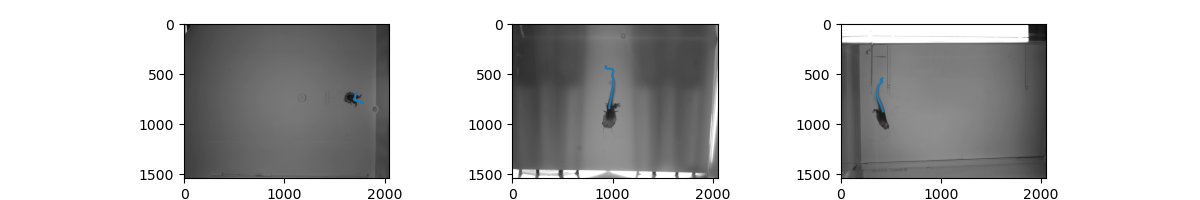

In [7]:
fig, ax = plt.subplots(1,3,figsize = (12,2))
ax[0].imshow(i0)
ax[0].plot(p0[:,0], p0[:,1])

ax[1].imshow(i1)
ax[1].plot(p1[:,0], p1[:,1])

ax[2].imshow(i2)
ax[2].plot(p2[:,0], p2[:,1])

In [8]:
# In this case, Camera1 and Camera2 (not Camera0) are more likely to return appropriate correspondences

In [9]:
pts_pairs = np.zeros((3, 100*100, 2))
pts_pairs[0] = np.nan
for i in range(100):
    for j in range(100):
        pts_pairs[1][i*100 + j] = p1[i]
        pts_pairs[2][i*100 + j] = p2[j]

In [10]:
pts3d = calibration_.triangulate(pts_pairs, progress=True)
reproj_err = calibration_.reprojection_error(pts3d, pts_pairs, mean=True)
residuals_ = np.reshape(reproj_err, (100, 100))

100%|█████████████████████████| 10000/10000 [00:07<00:00, 1383.34it/s]


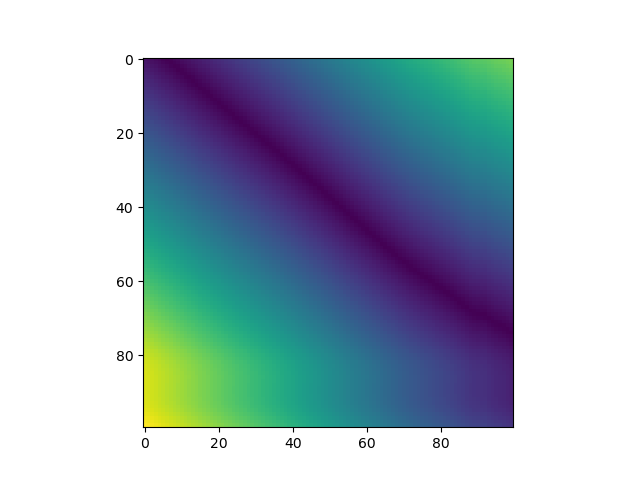

In [11]:
fig, ax = plt.subplots()
ax.imshow(residuals_)

In [28]:
def djikstra_walk(array_):
    '''
    Finds the shortest path through the array_ using Djikstra's algorithm
    '''
    #Initiate all the required arrays
    curr_ = np.array([0, np.argmin(residuals_[0])])
    visited_ = np.zeros(array_.shape, dtype = np.bool_)
    previous_ = np.zeros((array_.shape[0], array_.shape[1], 2), dtype = np.int32)
    previous_[tuple(curr_)] = [-1, -1]
    distances_ = np.ones(array_.shape)*np.inf
    distances_[tuple(curr_)] = array_[tuple(curr_)]
    path_ = []
    
    while(curr_[0] < 99 and curr_[1] < 99):
        visited_[tuple(curr_)] = 1
        min_ = np.inf
        argmin_ = curr_
        neighbours = get_neighbours(array_.shape, curr_)
        for ng in neighbours:
            # Update Distances
            if distances_[tuple(curr_)]+array_[tuple(ng)] < distances_[tuple(ng)]:
                distances_[tuple(ng)] = distances_[tuple(curr_)]+array_[tuple(ng)]
                previous_[tuple(ng)] = curr_
            if visited_[tuple(ng)]:
                continue
            # Choose the next node. Ignore visited nodes
            if distances_[tuple(ng)] < min_:
                min_ = distances_[tuple(ng)]
                argmin_ = ng;
        curr_ = argmin_
    
    # Traceback the path from the linked list
    while (curr_ != [-1, -1]).all():
        path_.append(curr_)
        curr_ = previous_[tuple(curr_)]
    path_ = np.flip(path_, axis = 0)
    
    return path_

In [29]:
def get_neighbours(shp, curr_):
    x = range(max(0, curr_[0] - 1),min(curr_[0] + 2, shp[0]))
    y = range(max(0, curr_[1] - 1),min(curr_[1] + 2, shp[1]))
    neighbours = np.array(np.meshgrid(x,y)).T.reshape(-1, 2)
    return neighbours

In [30]:
path_ = djikstra_walk(residuals_)

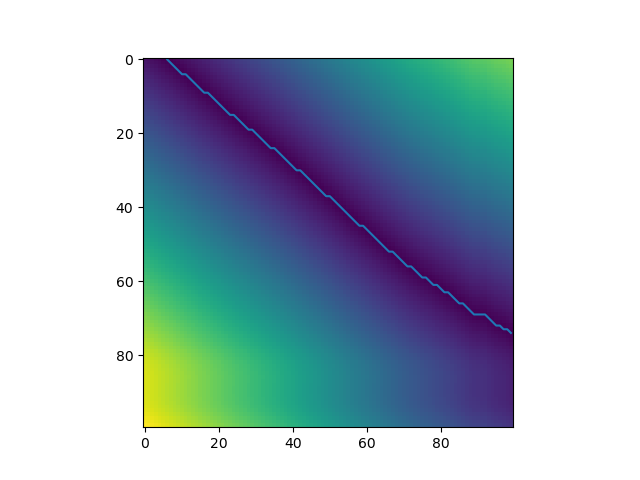

In [33]:
fig, ax = plt.subplots()
ax.imshow(residuals_)
ax.plot(path_[:,1], path_[:,0])

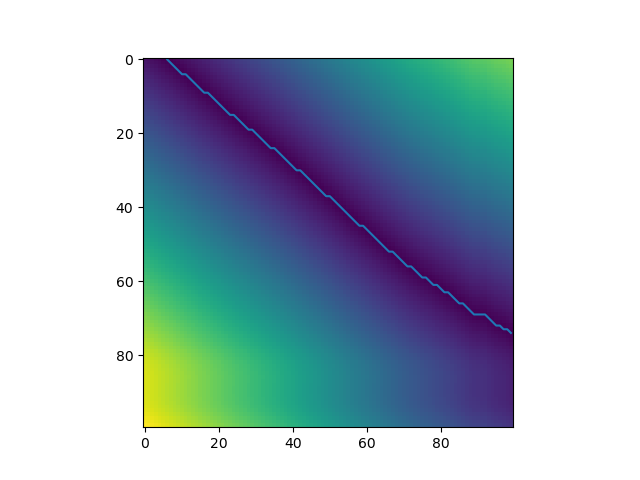